In [1]:
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.datasets import ImageFolder
import torch
from torchmetrics import Accuracy, F1Score, Precision, Recall
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, ConcatDataset
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np

In [2]:
CDP_data = ImageFolder('../data_retrieval/CDP_data/',ResNet101_Weights.IMAGENET1K_V2.transforms())
train_data = ImageFolder('../data_retrieval/data', ResNet101_Weights.IMAGENET1K_V2.transforms())
targets = train_data.targets
train_indices, test_indices = train_test_split(np.arange(len(targets)), stratify=targets, train_size=0.9, random_state=21)
train = Subset(train_data, indices=train_indices)
test_data_ebl = Subset(train_data, indices=test_indices)
test_data = ConcatDataset([CDP_data, test_data_ebl])

In [3]:
model = resnet101()

In [4]:
model.load_state_dict(torch.load('../models/models_weights/resnet101_bigger_train_size_with_broken.pth'))

<All keys matched successfully>

In [5]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
test_loader = torch.utils.data.DataLoader(test_data,
                                             batch_size=16, shuffle=True,
                                             num_workers=4)

In [7]:
print("Size of test dataset:", len(test_data))

Size of test dataset: 1507


In [8]:
idx_to_class = {v: k for k, v in CDP_data.class_to_idx.items()}

In [9]:
print(idx_to_class)

{0: 'E_Neo-Assyrian', 1: 'E_Neo-Babylonian', 2: 'GAR_Neo-Assyrian', 3: 'GAR_Neo-Babylonian', 4: 'KA_Neo-Assyrian', 5: 'KA_Neo-Babylonian', 6: 'KI_Neo-Assyrian', 7: 'KI_Neo-Babylonian', 8: 'MEŠ_Neo-Assyrian', 9: 'MEŠ_Neo-Babylonian', 10: 'NI_Neo-Assyrian', 11: 'NI_Neo-Babylonian', 12: 'RU_Neo-Assyrian', 13: 'RU_Neo-Babylonian', 14: 'TA_Neo-Assyrian', 15: 'TA_Neo-Babylonian', 16: 'TI_Neo-Assyrian', 17: 'TI_Neo-Babylonian', 18: 'U₂_Neo-Assyrian', 19: 'U₂_Neo-Babylonian', 20: 'ŠU_Neo-Assyrian', 21: 'ŠU_Neo-Babylonian'}


In [10]:
correct_pred = {classname: 0 for classname in idx_to_class}
total_pred = {classname: 0 for classname in idx_to_class}
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if idx_to_class[int(label)] == idx_to_class[(int(prediction))]:
                correct_pred[int(label)] += 1
            total_pred[int(label)] += 1

In [11]:
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {idx_to_class[classname]:5s} is {accuracy:.1f} %')

Accuracy for class: E_Neo-Assyrian is 87.7 %
Accuracy for class: E_Neo-Babylonian is 88.9 %
Accuracy for class: GAR_Neo-Assyrian is 78.3 %
Accuracy for class: GAR_Neo-Babylonian is 94.4 %
Accuracy for class: KA_Neo-Assyrian is 92.7 %
Accuracy for class: KA_Neo-Babylonian is 83.2 %
Accuracy for class: KI_Neo-Assyrian is 89.1 %
Accuracy for class: KI_Neo-Babylonian is 94.6 %
Accuracy for class: MEŠ_Neo-Assyrian is 88.9 %
Accuracy for class: MEŠ_Neo-Babylonian is 95.1 %
Accuracy for class: NI_Neo-Assyrian is 88.7 %
Accuracy for class: NI_Neo-Babylonian is 97.1 %
Accuracy for class: RU_Neo-Assyrian is 95.9 %
Accuracy for class: RU_Neo-Babylonian is 96.9 %
Accuracy for class: TA_Neo-Assyrian is 85.2 %
Accuracy for class: TA_Neo-Babylonian is 95.3 %
Accuracy for class: TI_Neo-Assyrian is 89.1 %
Accuracy for class: TI_Neo-Babylonian is 92.5 %
Accuracy for class: U₂_Neo-Assyrian is 74.2 %
Accuracy for class: U₂_Neo-Babylonian is 89.4 %
Accuracy for class: ŠU_Neo-Assyrian is 79.3 %
Accuracy for

In [12]:
print("Overall accuracy: ",sum(correct_pred.values()) / sum(total_pred.values()))

Overall accuracy:  0.8984737889847378


In [14]:
true_values = torch.zeros(len(test_data), dtype=torch.int64)
preds = torch.zeros(len(test_data), 1000)
counter = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        for pred,label  in zip(outputs, labels):
            preds[counter] = pred
            true_values[counter] = int(label)
            counter += 1
            

In [15]:
accuracy_2 = Accuracy('multiclass', num_classes=1000, top_k=2)
accuracy_3 = Accuracy('multiclass', num_classes=1000, top_k=3)
top_2 = accuracy_2(preds, true_values)
top_3 = accuracy_3(preds, true_values)
print("Overall Top-2 accuracy: ",float(top_2))
print("Overall Top-3 accuracy: ",float(top_3))

Overall Top-2 accuracy:  0.9535501003265381
Overall Top-3 accuracy:  0.9688122272491455


In [16]:
cf_matrix = confusion_matrix(true_values, torch.max(preds,1)[1])
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [idx_to_class[i] for i in idx_to_class],
                    columns = [idx_to_class[i] for i in idx_to_class])

<Axes: >

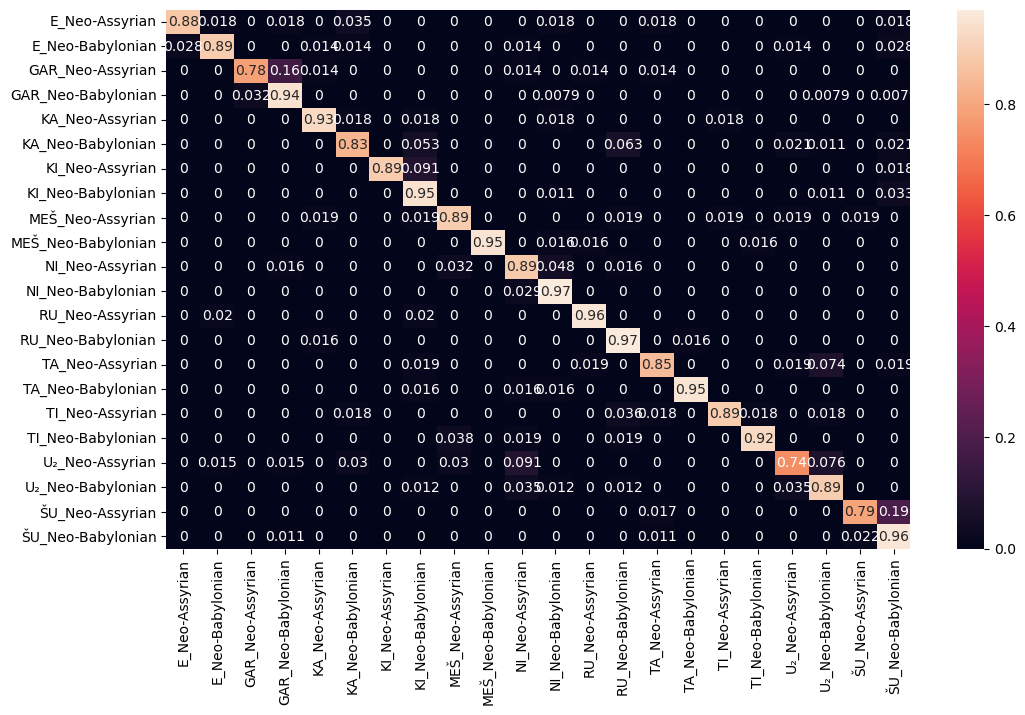

In [17]:
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [18]:
precision = Precision('multiclass',num_classes=22,average='none')

In [19]:
precision_each_class = precision(torch.max(preds,1)[1], true_values)

In [20]:
print(precision_each_class)

tensor([0.9615, 0.9552, 0.9310, 0.8881, 0.9273, 0.9186, 1.0000, 0.8447, 0.8889,
        1.0000, 0.7857, 0.8684, 0.9400, 0.8378, 0.9020, 0.9839, 0.9608, 0.9608,
        0.8596, 0.8539, 0.9388, 0.8018])
